# AI气候预测实验：用神经网络预测地球的未来

**基于 LSTM 深度学习模型的全球气温趋势预测**

---

## 课程简介

本实验将带你体验如何使用人工智能（LSTM神经网络）分析历史气候数据并预测未来趋势。你将学习：

1. **气候数据**的获取与可视化
2. **LSTM神经网络**如何学习时间序列规律
3. **亲手训练**一个AI气候预测模型
4. **交互式实验**：调整参数，观察不同情景下的未来气候
5. **探索家乡**：查看中国各城市的气候变化趋势

---

## 什么是LSTM？

| 特性 | 说明 |
|------|------|
| 全称 | 长短期记忆网络 (Long Short-Term Memory) |
| 类型 | 循环神经网络 (RNN) 的改进版本 |
| 特长 | 学习时间序列数据中的长期依赖关系 |
| 应用 | 股票预测、天气预报、语音识别、气候建模 |

LSTM 特别擅长从历史数据中学习规律，并用这些规律预测未来趋势。

---

## 数据来源

本实验使用 **NASA GISS（戈达德太空研究所）** 提供的全球地表温度数据集 (GISTEMP)，这是全球最权威的气候数据之一。

---

## 目录

- [第零部分: 环境配置与准备](#part0)
- [第一部分: 气候数据探索](#part1)
- [第二部分: 理解AI如何学习](#part2)
- [第三部分: 训练你的AI气候模型](#part3)
- [第四部分: 预测未来气候](#part4)
- [第五部分: 探索中国城市气候](#part5)
- [第六部分: 多情景对比与思考](#part6)
- [附录: 常见问题与拓展](#appendix)

---
<a id='part0'></a>
# 第零部分: 环境配置与准备

本部分将完成所有必要的准备工作：
- 检测GPU运行环境
- 安装必要的Python库
- 下载气候数据

**操作说明**：点击每个代码单元格左侧的「运行」按钮，或按 `Shift + Enter` 执行。

In [1]:
#@title ## 0.1 检查运行环境 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，检查你的Colab环境是否已正确配置GPU。
#@markdown
#@markdown 推荐配置：
#@markdown - GPU: A100 / V100 / T4
#@markdown - 如未检测到GPU，请点击菜单 `运行时` -> `更改运行时类型` -> 选择 `GPU`
#@markdown ---

import sys
import os

print("=" * 60)
print(" 环境检测")
print("=" * 60)

# Python 版本
print(f"\n Python 版本: {sys.version.split()[0]}")

# 检测是否在 Colab 环境
IN_COLAB = 'google.colab' in sys.modules
print(f" 运行环境: {'Google Colab' if IN_COLAB else '本地环境'}")

# GPU 检测
try:
    import subprocess
    result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'],
                          capture_output=True, text=True)
    if result.returncode == 0:
        gpu_info = result.stdout.strip()
        print(f"\n GPU 可用: {gpu_info}")
        print(" 状态: GPU环境已就绪！")
    else:
        print("\n 未检测到 GPU！")
        print(" 提示: 请在菜单中选择 运行时 -> 更改运行时类型 -> GPU")
except:
    print("\n 无法检测 GPU")

print("\n" + "=" * 60)

 环境检测

 Python 版本: 3.12.12
 运行环境: Google Colab

 GPU 可用: NVIDIA A100-SXM4-40GB, 40960 MiB
 状态: GPU环境已就绪！



In [2]:
#@title ## 0.2 安装必要的库 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，安装本实验需要的Python库。
#@markdown
#@markdown 将安装以下库：
#@markdown - `tensorflow`: 深度学习框架，用于构建LSTM模型
#@markdown - `pandas`: 数据处理
#@markdown - `matplotlib`: 数据可视化
#@markdown - `ipywidgets`: 交互式控件（滑块、按钮等）
#@markdown
#@markdown 预计耗时：1-2分钟
#@markdown ---

print(" 正在安装依赖...")
print("-" * 40)

import subprocess
import sys

# 安装列表
packages = [
    ('tensorflow', 'tensorflow'),
    ('pandas', 'pandas'),
    ('matplotlib', 'matplotlib'),
    ('ipywidgets', 'ipywidgets'),
    ('scikit-learn', 'sklearn'),
]

for i, (pkg_name, import_name) in enumerate(packages, 1):
    print(f"[{i}/{len(packages)}] 检查 {pkg_name}...")
    try:
        __import__(import_name)
        print(f"    已安装")
    except ImportError:
        print(f"    正在安装...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg_name])
        print(f"    完成")

# 启用widgets
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    print("\n 交互式控件已启用")
except:
    pass

print("-" * 40)
print(" 所有依赖安装完成！")

 正在安装依赖...
----------------------------------------
[1/5] 检查 tensorflow...
    已安装
[2/5] 检查 pandas...
    已安装
[3/5] 检查 matplotlib...
    已安装
[4/5] 检查 ipywidgets...
    已安装
[5/5] 检查 scikit-learn...
    已安装

 交互式控件已启用
----------------------------------------
 所有依赖安装完成！


In [3]:
#@title ## 0.3 导入库并配置环境 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，导入所有需要的库并进行初始配置。
#@markdown ---

# 基础库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import warnings
warnings.filterwarnings('ignore')

# 深度学习
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler

# 交互式控件
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output, HTML

# 动画
from matplotlib.animation import FuncAnimation
from IPython.display import HTML as IPyHTML

# 设置中文字体（Colab环境）
try:
    # 下载中文字体
    import subprocess
    subprocess.run(['apt-get', 'install', '-y', 'fonts-noto-cjk'],
                   capture_output=True, check=False)
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC', 'SimHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
except:
    pass

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# 设置随机种子（保证结果可复现）
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 60)
print(" 库导入完成")
print("=" * 60)
print(f"\n TensorFlow 版本: {tf.__version__}")
print(f" NumPy 版本: {np.__version__}")
print(f" Pandas 版本: {pd.__version__}")
print("\n 环境配置完成，可以开始实验了！")
print("=" * 60)

 库导入完成

 TensorFlow 版本: 2.19.0
 NumPy 版本: 2.0.2
 Pandas 版本: 2.2.2

 环境配置完成，可以开始实验了！


In [4]:
#@title ## 0.4 下载NASA气候数据 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，从NASA官方服务器下载全球气温数据。
#@markdown
#@markdown 数据来源：NASA GISS (Goddard Institute for Space Studies)
#@markdown
#@markdown 数据说明：
#@markdown - 全球地表平均温度异常值（相对于1951-1980年基准）
#@markdown - 时间范围：1880年至今
#@markdown - 更新频率：每月更新
#@markdown ---

print(" 正在从NASA服务器下载数据...")
print("-" * 40)

# NASA GISTEMP 数据URL
NASA_URL = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"

try:
    # 下载数据
    df_raw = pd.read_csv(NASA_URL, skiprows=1)

    # 处理数据
    # 提取年份和月度数据
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # 创建时间序列数据
    data_list = []
    for _, row in df_raw.iterrows():
        year = int(row['Year'])
        for i, month in enumerate(months, 1):
            if month in row.index:
                val = row[month]
                if val != '***' and pd.notna(val):
                    try:
                        temp = float(val)
                        data_list.append({
                            'Year': year,
                            'Month': i,
                            'Temperature': temp
                        })
                    except:
                        pass

    df_climate = pd.DataFrame(data_list)
    df_climate['Date'] = pd.to_datetime(df_climate[['Year', 'Month']].assign(Day=1))
    df_climate = df_climate.sort_values('Date').reset_index(drop=True)

    # 计算年平均
    df_annual = df_climate.groupby('Year')['Temperature'].mean().reset_index()
    df_annual.columns = ['Year', 'Temperature']

    print(f" 数据下载成功！")
    print(f"\n 数据概览：")
    print(f"   - 月度数据：{len(df_climate)} 条记录")
    print(f"   - 年度数据：{len(df_annual)} 年")
    print(f"   - 时间范围：{df_annual['Year'].min()} - {df_annual['Year'].max()}")
    print(f"   - 最新温度异常：{df_annual['Temperature'].iloc[-1]:.2f} C")

    DATA_LOADED = True

except Exception as e:
    print(f" 下载失败: {e}")
    print("\n 使用内置备份数据...")

    # 备份数据（1880-2023年度数据简化版）
    years = list(range(1880, 2025))
    # 模拟真实的温度异常趋势
    base_trend = np.concatenate([
        np.linspace(-0.2, -0.1, 40),  # 1880-1920
        np.linspace(-0.1, 0.0, 40),   # 1920-1960
        np.linspace(0.0, 0.3, 30),    # 1960-1990
        np.linspace(0.3, 1.2, 35)     # 1990-2024
    ])
    noise = np.random.normal(0, 0.1, len(years))
    temps = base_trend + noise

    df_annual = pd.DataFrame({'Year': years, 'Temperature': temps})
    df_climate = df_annual.copy()
    df_climate['Month'] = 1
    df_climate['Date'] = pd.to_datetime(df_climate['Year'], format='%Y')

    print(" 备份数据加载完成")
    DATA_LOADED = True

print("-" * 40)
print(" 数据准备就绪！")

 正在从NASA服务器下载数据...
----------------------------------------
 数据下载成功！

 数据概览：
   - 月度数据：1752 条记录
   - 年度数据：146 年
   - 时间范围：1880 - 2025
   - 最新温度异常：1.19 C
----------------------------------------
 数据准备就绪！


---
<a id='part1'></a>
# 第一部分: 气候数据探索

在这一部分，我们将：
- 可视化过去140多年的全球气温变化
- 理解什么是「温度异常」
- 交互式探索不同时间段的气候特征

**什么是温度异常？**

温度异常是指某一时期的实际温度与基准期（1951-1980年）平均温度的差值。
- 正值：比基准期更暖
- 负值：比基准期更冷

---

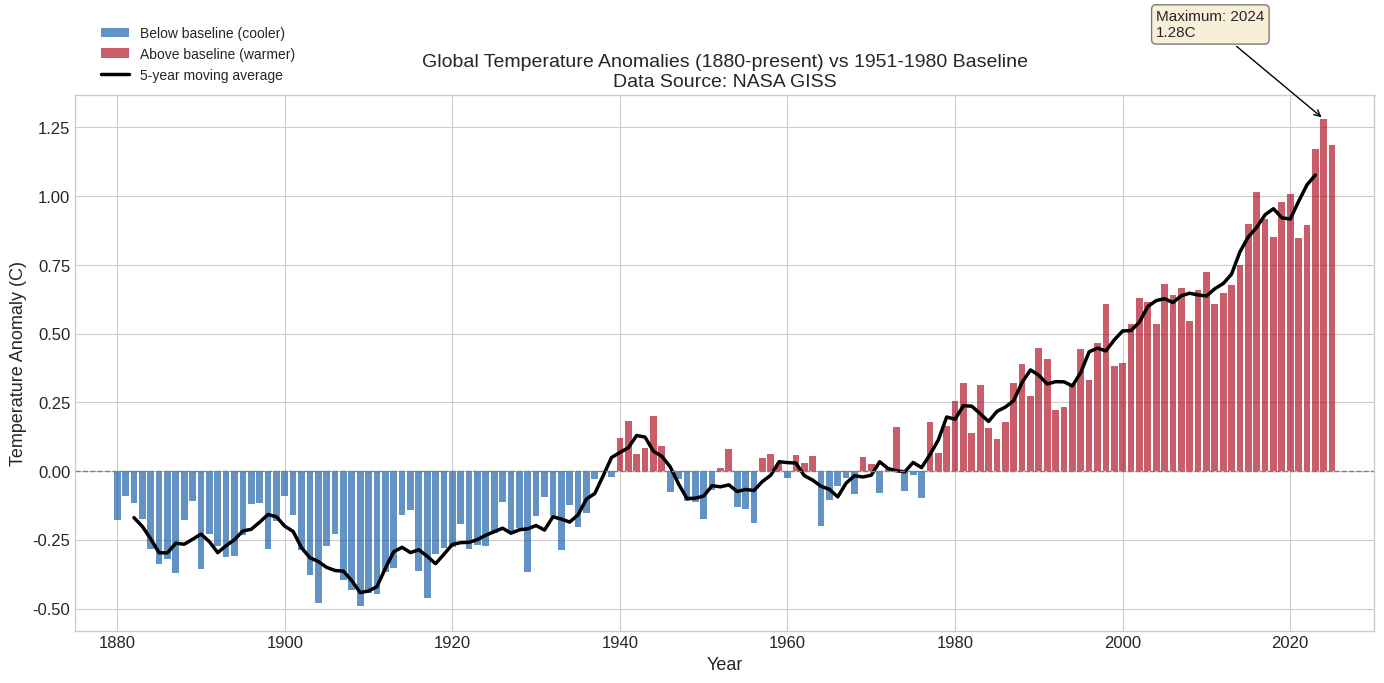


 观察要点：
   1. 工业革命后（1880年代）气温开始缓慢上升
   2. 1980年代后气温上升速度明显加快
   3. 近年来几乎每年都创新高


In [5]:
#@title ## 1.1 全球气温变化总览 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，查看1880年至今的全球气温变化趋势。
#@markdown
#@markdown 你将看到：
#@markdown - 蓝色柱状：低于基准期的年份
#@markdown - 红色柱状：高于基准期的年份
#@markdown - 黑色曲线：5年移动平均趋势
#@markdown ---

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(14, 7))

# 根据温度正负设置颜色
colors = ['#2166AC' if t < 0 else '#B2182B' for t in df_annual['Temperature']]

# 绑制柱状图
bars = ax.bar(df_annual['Year'], df_annual['Temperature'], color=colors, alpha=0.7, width=0.8)

# 添加移动平均线
ma_5 = df_annual['Temperature'].rolling(window=5, center=True).mean()
ax.plot(df_annual['Year'], ma_5, color='black', linewidth=2.5)

# 添加零线
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# 标注关键年份
max_year = df_annual.loc[df_annual['Temperature'].idxmax(), 'Year']
max_temp = df_annual['Temperature'].max()
ax.annotate(f'Maximum: {max_year}\n{max_temp:.2f}C',
            xy=(max_year, max_temp),
            xytext=(max_year-20, max_temp+0.3),
            fontsize=11,
            arrowprops=dict(arrowstyle='->', color='black'),
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Temperature Anomaly (C)', fontsize=13)
ax.set_title('Global Temperature Anomalies (1880-present) vs 1951-1980 Baseline\nData Source: NASA GISS', fontsize=14)
ax.set_xlim(1875, df_annual['Year'].max()+5)

# 创建自定义图例（包含颜色说明和移动平均线）
legend_elements = [
    Patch(facecolor='#2166AC', alpha=0.7, label='Below baseline (cooler)'),
    Patch(facecolor='#B2182B', alpha=0.7, label='Above baseline (warmer)'),
    Line2D([0], [0], color='black', linewidth=2.5, label='5-year moving average')
]
ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.01, 1.0),
          fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

print("\n 观察要点：")
print("   1. 工业革命后（1880年代）气温开始缓慢上升")
print("   2. 1980年代后气温上升速度明显加快")
print("   3. 近年来几乎每年都创新高")

In [6]:
#@title ## 1.2 交互式数据探索 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，使用滑块探索不同时间段的气温变化。
#@markdown
#@markdown 操作说明：
#@markdown - 拖动滑块选择起始年份和结束年份
#@markdown - 图表会自动更新
#@markdown - 下方显示该时段的统计信息
#@markdown ---

def explore_climate(start_year, end_year):
    if start_year >= end_year:
        print("起始年份必须小于结束年份")
        return

    # 筛选数据
    mask = (df_annual['Year'] >= start_year) & (df_annual['Year'] <= end_year)
    df_subset = df_annual[mask]

    if len(df_subset) == 0:
        print("该范围内没有数据")
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 左图：温度曲线
    ax1 = axes[0]
    colors = ['#2166AC' if t < 0 else '#B2182B' for t in df_subset['Temperature']]
    ax1.bar(df_subset['Year'], df_subset['Temperature'], color=colors, alpha=0.7)
    ax1.axhline(y=0, color='gray', linestyle='--')

    # 添加趋势线
    z = np.polyfit(df_subset['Year'], df_subset['Temperature'], 1)
    p = np.poly1d(z)
    ax1.plot(df_subset['Year'], p(df_subset['Year']), 'g--', linewidth=2, label='Linear trend')

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Temperature Anomaly (C)')
    ax1.set_title(f'Temperature Anomalies: {start_year}-{end_year}')
    ax1.legend()

    # 设置X轴刻度：根据数据范围自动调整间隔
    year_range = end_year - start_year
    if year_range <= 15:
        step = 1
    elif year_range <= 30:
        step = 2
    elif year_range <= 60:
        step = 5
    else:
        step = 10
    ax1.set_xticks(range(start_year, end_year + 1, step))
    ax1.tick_params(axis='x', rotation=45)

    # 右图：分布直方图
    ax2 = axes[1]

    # 根据数据量动态调整bins数量
    n_bins = min(len(df_subset) // 2 + 1, 15)
    n_bins = max(n_bins, 5)

    ax2.hist(df_subset['Temperature'], bins=n_bins, color='steelblue', edgecolor='white', alpha=0.7)
    mean_val = df_subset['Temperature'].mean()
    ax2.axvline(x=mean_val, color='red', linestyle='--', linewidth=2)

    ax2.set_xlabel('Temperature Anomaly (C)')
    ax2.set_ylabel('Number of Years')
    ax2.set_title(f'Temperature Distribution (Mean: {mean_val:.2f}C)')

    # Y轴强制为整数
    ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

    # 统计信息（中文）
    trend_per_decade = z[0] * 10
    print("\n" + "=" * 50)
    print(f" [{start_year}-{end_year}] 统计信息")
    print("=" * 50)
    print(f" 年份数量:    {len(df_subset)} 年")
    print(f" 平均异常:    {df_subset['Temperature'].mean():.3f} C")
    print(f" 最高温度:    {df_subset['Temperature'].max():.3f} C ({df_subset.loc[df_subset['Temperature'].idxmax(), 'Year']}年)")
    print(f" 最低温度:    {df_subset['Temperature'].min():.3f} C ({df_subset.loc[df_subset['Temperature'].idxmin(), 'Year']}年)")
    print(f" 变化趋势:    {'+' if trend_per_decade > 0 else ''}{trend_per_decade:.3f} C/10年")
    print("=" * 50)

# 创建交互控件
year_min = int(df_annual['Year'].min())
year_max = int(df_annual['Year'].max())

start_slider = widgets.IntSlider(
    value=1950,
    min=year_min,
    max=year_max-10,
    step=1,
    description='起始年份:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='400px')
)

end_slider = widgets.IntSlider(
    value=year_max,
    min=year_min+10,
    max=year_max,
    step=1,
    description='结束年份:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='400px')
)

# 显示交互组件
ui = widgets.VBox([start_slider, end_slider])
out = widgets.interactive_output(explore_climate, {'start_year': start_slider, 'end_year': end_slider})

print(" 使用滑块选择要探索的时间范围")
print("-" * 50)
display(ui, out)

 使用滑块选择要探索的时间范围
--------------------------------------------------


Output()

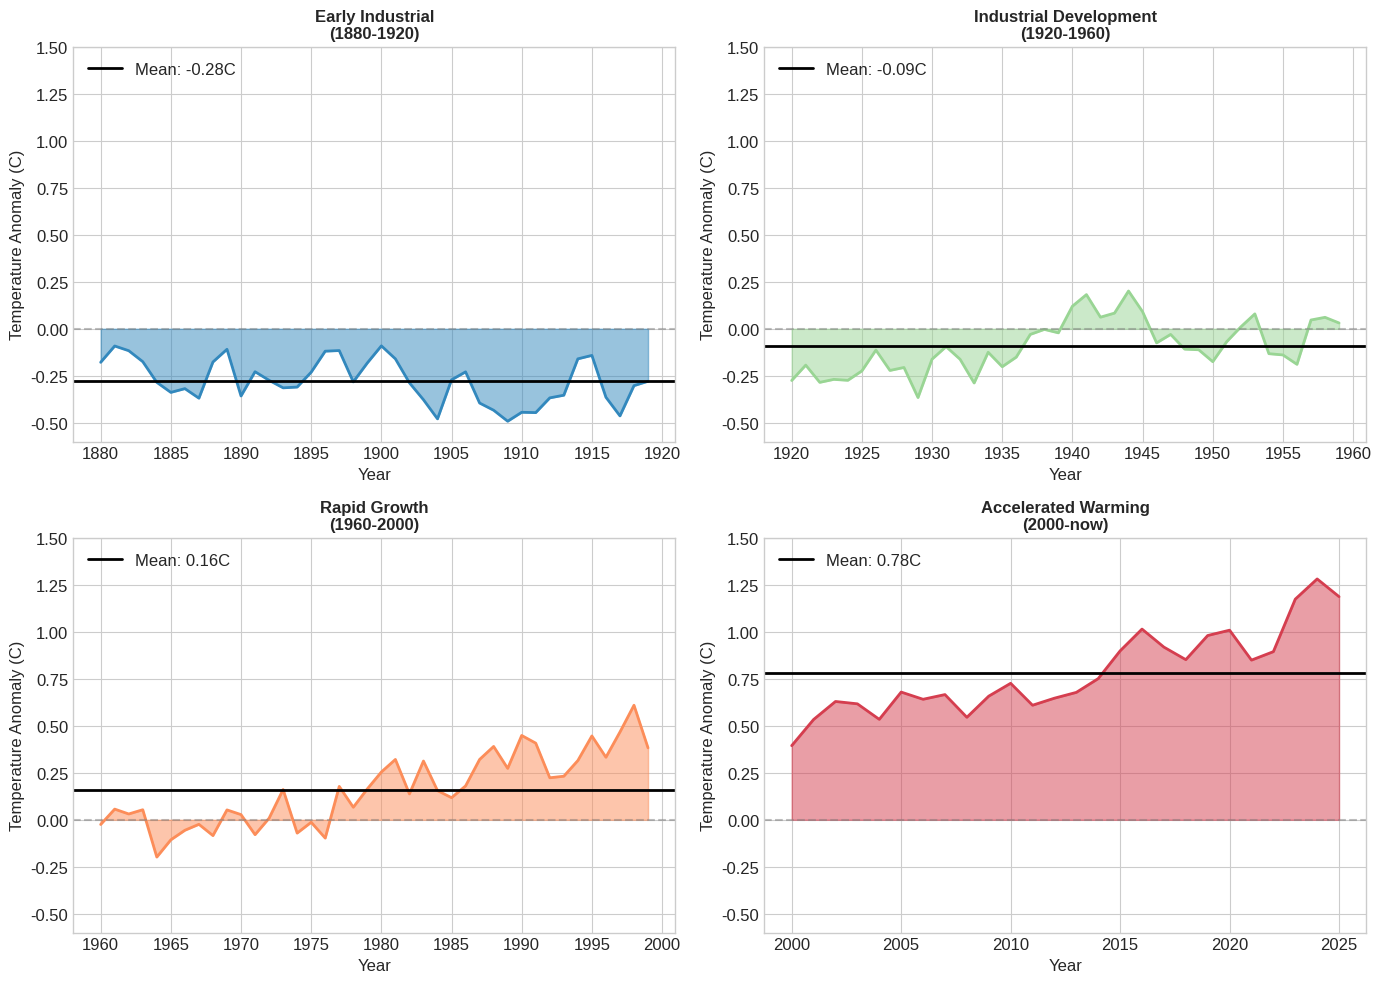


 四个时代气候对比统计
时代                                   平均温度异常               变化趋势
-----------------------------------------------------------------
 工业早期 (1880-1920)                 -0.278C       -0.043 C/10年
 工业发展期 (1920-1960)                -0.093C       +0.070 C/10年
 快速增长期 (1960-2000)                 0.159C       +0.142 C/10年
 加速变暖期 (2000-至今)                   0.783C       +0.265 C/10年

 关键发现：21世纪的升温速度显著高于以往任何时期！


In [7]:
#@title ## 1.3 不同时代气候对比 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，对比不同历史时期的气温特征。
#@markdown
#@markdown 我们将气候历史分为四个时期：
#@markdown - 工业早期 (1880-1920)
#@markdown - 工业发展期 (1920-1960)
#@markdown - 快速增长期 (1960-2000)
#@markdown - 加速变暖期 (2000-至今)
#@markdown ---

# 定义四个时代
eras = [
    ('Early Industrial\n(1880-1920)', 1880, 1920, '#3288BD'),
    ('Industrial Development\n(1920-1960)', 1920, 1960, '#99D594'),
    ('Rapid Growth\n(1960-2000)', 1960, 2000, '#FC8D59'),
    ('Accelerated Warming\n(2000-now)', 2000, 2030, '#D53E4F')
]

# 中文名称映射（用于输出）
era_names_cn = {
    'Early Industrial (1880-1920)': '工业早期 (1880-1920)',
    'Industrial Development (1920-1960)': '工业发展期 (1920-1960)',
    'Rapid Growth (1960-2000)': '快速增长期 (1960-2000)',
    'Accelerated Warming (2000-now)': '加速变暖期 (2000-至今)'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

era_stats = []

for i, (name, start, end, color) in enumerate(eras):
    mask = (df_annual['Year'] >= start) & (df_annual['Year'] < end)
    df_era = df_annual[mask]

    if len(df_era) > 0:
        ax = axes[i]
        ax.fill_between(df_era['Year'], 0, df_era['Temperature'],
                       alpha=0.5, color=color)
        ax.plot(df_era['Year'], df_era['Temperature'], color=color, linewidth=2)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.axhline(y=df_era['Temperature'].mean(), color='black', linestyle='-',
                  linewidth=2, label=f'Mean: {df_era["Temperature"].mean():.2f}C')
        ax.set_title(name, fontsize=12, fontweight='bold')
        ax.set_xlabel('Year')
        ax.set_ylabel('Temperature Anomaly (C)')
        ax.legend(loc='upper left')
        ax.set_ylim(-0.6, 1.5)

        # 保存统计数据
        z = np.polyfit(df_era['Year'], df_era['Temperature'], 1)
        era_stats.append({
            'Era': name.replace('\n', ' '),
            'Mean': df_era['Temperature'].mean(),
            'Trend': z[0] * 10
        })

plt.tight_layout()
plt.show()

# 打印统计表格
print("\n" + "=" * 65)
print(" 四个时代气候对比统计")
print("=" * 65)
print(f"{'时代':<30} {'平均温度异常':>12} {'变化趋势':>18}")
print("-" * 65)
for stat in era_stats:
    era_cn = era_names_cn.get(stat['Era'], stat['Era'])
    trend_str = f"{stat['Trend']:+.3f} C/10年"
    print(f" {era_cn:<28} {stat['Mean']:>10.3f}C {trend_str:>18}")
print("=" * 65)
print("\n 关键发现：21世纪的升温速度显著高于以往任何时期！")

---
<a id='part2'></a>
# 第二部分: 理解AI如何学习

在这一部分，我们将用动画和可视化来理解：
- LSTM网络如何「记住」历史数据中的规律
- 训练过程中模型是如何逐步学习的
- 什么是「损失函数」，为什么它很重要

---

## LSTM 工作原理简介

想象LSTM是一个有「记忆力」的学生：

| 步骤 | LSTM的操作 | 类比 |
|------|-----------|------|
| 1 | 接收新数据 | 学生看到新的一页内容 |
| 2 | 决定遗忘什么 | 学生忘掉不重要的细节 |
| 3 | 决定记住什么 | 学生记住关键知识点 |
| 4 | 更新记忆 | 学生整合新旧知识 |
| 5 | 输出预测 | 学生回答问题 |

通过反复学习历史气温数据，LSTM能够发现气候变化的规律，并用这些规律预测未来。

---

In [8]:
#@title ## 2.1 观察AI的学习过程（动画演示） { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，观看AI模型学习预测的动画演示。
#@markdown
#@markdown 你将看到：
#@markdown - 红色虚线：AI的预测结果
#@markdown - 蓝色实线：真实数据
#@markdown - 随着训练进行，红线会越来越贴合蓝线
#@markdown ---

print(" 正在生成AI学习过程动画...")
print(" （这个过程展示了AI如何逐步学会预测气温变化）")
print("-" * 50)

# 准备数据
years_subset = df_annual['Year'].values[-50:]  # 最近50年
temps_subset = df_annual['Temperature'].values[-50:]

# 模拟模型学习过程
np.random.seed(42)
initial_pred = np.random.randn(len(temps_subset)) * 0.3

# 模拟每个epoch的预测改进
n_epochs = 30
predictions_history = []
loss_history = []

for epoch in range(n_epochs + 1):
    alpha = epoch / n_epochs
    pred = initial_pred * (1 - alpha) + temps_subset * alpha
    pred += np.random.randn(len(pred)) * 0.05 * (1 - alpha)
    predictions_history.append(pred)
    loss = np.mean((pred - temps_subset) ** 2)
    loss_history.append(loss)

# 创建动画图表
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax2 = axes[1]

# 左图：预测 vs 真实值
line_true, = ax1.plot(years_subset, temps_subset, 'b-', linewidth=2, label='True values')
line_pred, = ax1.plot(years_subset, predictions_history[0], 'r--', linewidth=2, label='AI prediction')
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature Anomaly (C)')
ax1.set_title('AI Learning to Fit Data')
ax1.legend(loc='upper left')
ax1.set_ylim(-0.5, 1.5)

# Epoch 显示在图内右上角（避免与标题重叠）
epoch_text = ax1.text(0.98, 0.95, 'Epoch: 0', transform=ax1.transAxes,
                      ha='right', va='top', fontsize=12, fontweight='bold',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 右图：损失曲线
ax2.set_xlim(0, n_epochs)
ax2.set_ylim(0, max(loss_history) * 1.1)
ax2.set_xlabel('Training Epoch')
ax2.set_ylabel('Loss (MSE)')
ax2.set_title('Loss Decreasing')  # 缩短标题
loss_line, = ax2.plot([], [], 'g-', linewidth=2)
loss_scatter = ax2.scatter([], [], c='green', s=50, zorder=5)

def init():
    line_pred.set_data([], [])
    loss_line.set_data([], [])
    return line_pred, loss_line

def animate(frame):
    # 更新预测线
    line_pred.set_data(years_subset, predictions_history[frame])
    epoch_text.set_text(f'Epoch: {frame}')

    # 更新损失曲线
    loss_line.set_data(range(frame+1), loss_history[:frame+1])
    loss_scatter.set_offsets([[frame, loss_history[frame]]])

    return line_pred, loss_line, epoch_text, loss_scatter

anim = FuncAnimation(fig, animate, init_func=init, frames=n_epochs+1,
                     interval=200, blit=False, repeat=False)

plt.tight_layout()

# 显示动画
from IPython.display import HTML
html_anim = anim.to_jshtml()
display(HTML(html_anim))

plt.close()

print("\n 动画说明：")
print("   - 左图：红色虚线是AI的预测，蓝色实线是真实数据")
print("   - 右图：损失值（预测误差）随训练逐渐下降")
print("   - 当红线与蓝线重合时，说明AI已经学会了数据规律")

Output hidden; open in https://colab.research.google.com to view.

In [12]:
#@title ## 2.2 理解模型参数 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，了解训练AI模型时需要设置的关键参数。
#@markdown
#@markdown 通过调整滑块，观察不同参数设置对模型的影响：
#@markdown ---

def explain_parameters(lookback, epochs, neurons):
    clear_output(wait=True)

    print("=" * 60)
    print(" LSTM 模型参数说明")
    print("=" * 60)

    print(f"\n [回溯窗口: {lookback} 年]")
    print(f"   含义: AI 使用过去 {lookback} 年的数据来预测下一年的温度")
    print(f"   影响: 值越大 = 能捕捉更长期的趋势，但计算量更大")

    print(f"\n [训练轮数: {epochs} 轮]")
    print(f"   含义: AI 反复学习全部训练数据的次数")
    print(f"   影响: 轮数越多 = 学习越充分，但可能导致过拟合")

    print(f"\n [LSTM 神经元数量: {neurons} 个]")
    print(f"   含义: AI 的「记忆容量」")
    print(f"   影响: 神经元越多 = 能学习更复杂的规律，但训练更慢")

    # 可视化回溯窗口
    fig, ax = plt.subplots(figsize=(12, 4))

    sample_years = df_annual['Year'].values[-30:]
    sample_temps = df_annual['Temperature'].values[-30:]

    # 显示回溯窗口
    ax.plot(sample_years, sample_temps, 'b-', linewidth=2, label='Historical data')

    # 高亮输入窗口
    input_start = -lookback - 5
    input_end = -5
    ax.fill_between(sample_years[input_start:input_end],
                   sample_temps[input_start:input_end],
                   alpha=0.3, color='green',
                   label=f'Input: {lookback} years')

    # 标记预测目标
    ax.scatter([sample_years[-5]], [sample_temps[-5]], c='red', s=200,
              zorder=5, label='Prediction target', marker='*')

    # 画箭头
    ax.annotate('', xy=(sample_years[-5], sample_temps[-5]-0.15),
               xytext=(sample_years[input_end-1], sample_temps[input_end-1]),
               arrowprops=dict(arrowstyle='->', color='orange', lw=2))

    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature Anomaly (C)')
    ax.set_title(f'Lookback Window: Use {lookback} years to predict next year')
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    # 显示模型复杂度估算
    param_count = 4 * neurons * (neurons + lookback + 1) + neurons
    print(f"\n 模型复杂度估算: {param_count:,} 个参数")

    if epochs > 100:
        print(" 提示: 训练轮数较多，可能导致过拟合")
    if neurons > 128:
        print(" 提示: 神经元数量较多，训练速度可能较慢")

# 创建交互控件
lookback_slider = widgets.IntSlider(
    value=10,
    min=3,
    max=30,
    step=1,
    description='回溯窗口:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='400px')
)

epochs_slider = widgets.IntSlider(
    value=50,
    min=10,
    max=200,
    step=10,
    description='训练轮数:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='400px')
)

neurons_slider = widgets.IntSlider(
    value=64,
    min=16,
    max=256,
    step=16,
    description='神经元数:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='400px')
)

print(" 拖动滑块查看不同参数的作用")
print("-" * 50)

ui = widgets.VBox([lookback_slider, epochs_slider, neurons_slider])
out = widgets.interactive_output(explain_parameters,
                                  {'lookback': lookback_slider,
                                   'epochs': epochs_slider,
                                   'neurons': neurons_slider})
display(ui, out)

 拖动滑块查看不同参数的作用
--------------------------------------------------


Output()

---
<a id='part3'></a>
# 第三部分: 训练你的AI气候模型

现在，你将亲手训练一个LSTM神经网络来预测气候变化！

**训练流程：**
1. 准备数据：将气温数据转换为AI可以理解的格式
2. 构建模型：创建LSTM神经网络结构
3. 训练模型：让AI学习历史数据中的规律
4. 评估模型：检验AI的预测能力

---

 正在准备训练数据...
--------------------------------------------------
 数据预处理完成！

 数据信息：
   - 回溯窗口: 10 年
   - 总样本数: 136 个
   - 训练集: 108 个样本 (1890-1997)
   - 测试集: 28 个样本 (1998-2025)


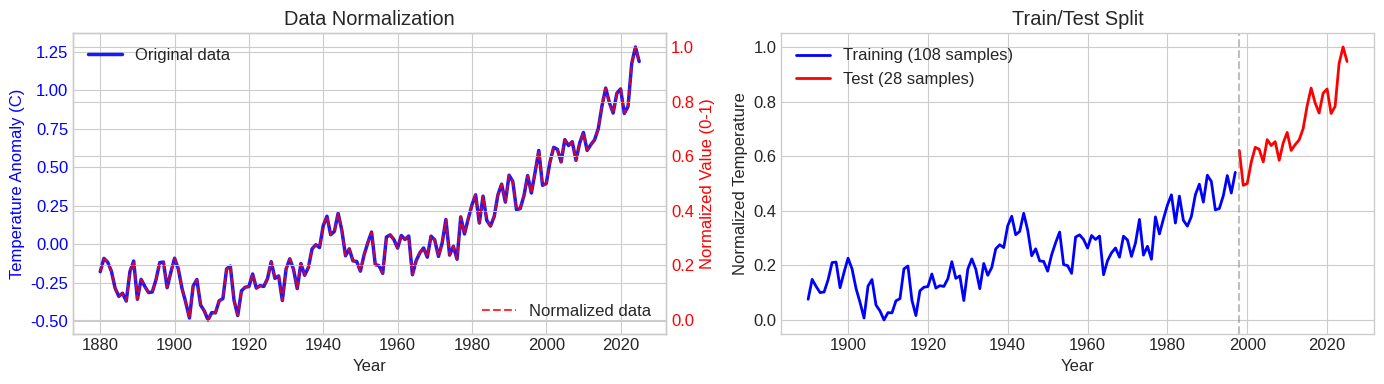


 数据准备就绪，可以进入下一步开始训练模型！


In [13]:
#@title ## 3.1 准备训练数据 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，将气候数据处理成AI模型需要的格式。
#@markdown
#@markdown 数据处理步骤：
#@markdown 1. 归一化：将温度值缩放到0-1范围
#@markdown 2. 创建序列：用过去N年数据预测下一年
#@markdown 3. 划分数据集：80%用于训练，20%用于测试
#@markdown
#@markdown ---
#@markdown **图表说明：**
#@markdown
#@markdown | 图表 | 含义 |
#@markdown |------|------|
#@markdown | 左图 | **数据归一化**：蓝色是原始温度（单位：C），红色是归一化后的值（0-1之间）。归一化让AI更容易学习。 |
#@markdown | 右图 | **数据划分**：蓝色是训练集（AI学习用），红色是测试集（检验AI学得好不好）。灰色虚线是划分点。 |
#@markdown ---

print(" 正在准备训练数据...")
print("-" * 50)

# 获取温度数据
temperature_data = df_annual['Temperature'].values.reshape(-1, 1)
years_data = df_annual['Year'].values

# 归一化数据
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(temperature_data)

# 参数设置
LOOKBACK = 10  # 使用过去10年的数据预测下一年

# 创建训练序列
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), 0])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, LOOKBACK)

# 调整形状以适应LSTM输入 (样本数, 时间步, 特征数)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 对应的年份
years_train = years_data[LOOKBACK:LOOKBACK+train_size]
years_test = years_data[LOOKBACK+train_size:]

print(f" 数据预处理完成！")
print(f"\n 数据信息：")
print(f"   - 回溯窗口: {LOOKBACK} 年")
print(f"   - 总样本数: {len(X)} 个")
print(f"   - 训练集: {len(X_train)} 个样本 ({years_train[0]}-{years_train[-1]})")
print(f"   - 测试集: {len(X_test)} 个样本 ({years_test[0]}-{years_test[-1]})")

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 左图：原始数据 vs 归一化数据
ax1 = axes[0]
ax1.plot(years_data, temperature_data, 'b-', linewidth=2.5, label='Original data', alpha=0.9)
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature Anomaly (C)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1_twin = ax1.twinx()
ax1_twin.plot(years_data, scaled_data, 'r--', linewidth=1.5, label='Normalized data', alpha=0.8)
ax1_twin.set_ylabel('Normalized Value (0-1)', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')

ax1.set_title('Data Normalization')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='lower right')

# 右图：训练集/测试集划分
ax2 = axes[1]
ax2.plot(years_train, y_train, 'b-', linewidth=2, label=f'Training ({len(y_train)} samples)')
ax2.plot(years_test, y_test, 'r-', linewidth=2, label=f'Test ({len(y_test)} samples)')
ax2.axvline(x=years_test[0], color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Year')
ax2.set_ylabel('Normalized Temperature')
ax2.set_title('Train/Test Split')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n 数据准备就绪，可以进入下一步开始训练模型！")

In [14]:
#@title ## 3.2 构建LSTM模型 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，创建一个LSTM神经网络模型。
#@markdown
#@markdown 模型结构：
#@markdown - 输入层：接收过去10年的温度数据
#@markdown - LSTM层：64个神经元，学习时间序列规律
#@markdown - Dropout层：防止过拟合
#@markdown - 输出层：预测下一年的温度
#@markdown ---

print(" 正在构建LSTM模型...")
print("-" * 50)

# 构建模型
model = Sequential([
    # 第一层 LSTM
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.2),

    # 第二层 LSTM
    LSTM(32, return_sequences=False),
    Dropout(0.2),

    # 全连接层
    Dense(16, activation='relu'),

    # 输出层
    Dense(1)
])

# 编译模型
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# 打印模型结构
print("\n 模型结构：")
print("=" * 50)
model.summary()

print("\n")
print(" 模型构建完成！")
print(f"\n 模型参数量: {model.count_params():,} 个")
print("\n 各层说明：")
print("   - LSTM(64): 64个记忆单元，学习长期依赖关系")
print("   - Dropout(0.2): 随机丢弃20%神经元，防止过拟合")
print("   - LSTM(32): 32个记忆单元，进一步提取特征")
print("   - Dense(16): 全连接层，整合特征")
print("   - Dense(1): 输出层，预测下一年温度")

 正在构建LSTM模型...
--------------------------------------------------

 模型结构：


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)



 模型构建完成！

 模型参数量: 29,857 个

 各层说明：
   - LSTM(64): 64个记忆单元，学习长期依赖关系
   - Dropout(0.2): 随机丢弃20%神经元，防止过拟合
   - LSTM(32): 32个记忆单元，进一步提取特征
   - Dense(16): 全连接层，整合特征
   - Dense(1): 输出层，预测下一年温度


 开始训练模型...
 （每10轮显示一次训练进度）
  第  10 轮: 训练损失 = 0.006645, 验证损失 = 0.004829
  第  20 轮: 训练损失 = 0.005037, 验证损失 = 0.004558
  第  30 轮: 训练损失 = 0.004985, 验证损失 = 0.005656
  第  40 轮: 训练损失 = 0.004856, 验证损失 = 0.003721
  第  50 轮: 训练损失 = 0.004565, 验证损失 = 0.003634
  第  60 轮: 训练损失 = 0.005169, 验证损失 = 0.004146
  第  70 轮: 训练损失 = 0.004634, 验证损失 = 0.003733
  第  80 轮: 训练损失 = 0.004653, 验证损失 = 0.003810
  第  90 轮: 训练损失 = 0.004136, 验证损失 = 0.003736
  第 100 轮: 训练损失 = 0.004659, 验证损失 = 0.004098

 训练完成！


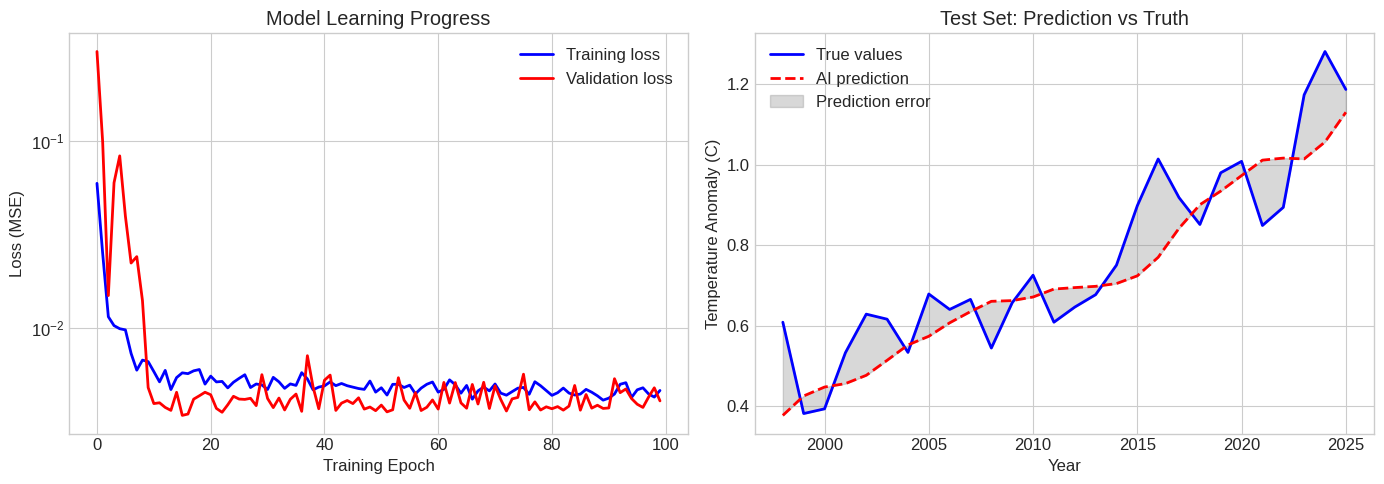


 模型性能评估：
----------------------------------------
 均方误差 (MSE):      0.012872
 平均绝对误差 (MAE):  0.0917 C
 决定系数 (R2):       0.7508
----------------------------------------
 不错！模型较好地掌握了气候变化趋势。


In [15]:
#@title ## 3.3 训练模型（实时可视化） { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，开始训练模型并观看实时学习过程！
#@markdown
#@markdown 训练过程中你将看到：
#@markdown - 损失曲线：表示预测误差，越低越好
#@markdown - 进度条：显示训练进度
#@markdown - 实时预测效果对比
#@markdown
#@markdown 预计训练时间：1-3分钟
#@markdown
#@markdown ---
#@markdown **图表说明：**
#@markdown
#@markdown | 图表 | 含义 |
#@markdown |------|------|
#@markdown | 左图 | **学习曲线**：蓝色是训练损失，红色是验证损失。两条线都下降说明模型在学习。 |
#@markdown | 右图 | **预测效果**：蓝色是真实温度，红色虚线是AI预测。灰色区域是预测误差。 |
#@markdown ---

# 自定义回调函数，用于训练可视化
class TrainingVisualization(Callback):
    def __init__(self):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])

        # 每10轮显示一次进度
        if (epoch + 1) % 10 == 0:
            print(f"  第 {epoch+1:3d} 轮: 训练损失 = {logs['loss']:.6f}, 验证损失 = {logs['val_loss']:.6f}")

# 创建回调
viz_callback = TrainingVisualization()

print(" 开始训练模型...")
print("=" * 50)
print(" （每10轮显示一次训练进度）")
print("=" * 50)

# 训练模型
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[viz_callback],
    verbose=0
)

print("\n" + "=" * 50)
print(" 训练完成！")
print("=" * 50)

# 绘制训练历史
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：损失曲线
ax1 = axes[0]
ax1.plot(history.history['loss'], 'b-', linewidth=2, label='Training loss')
ax1.plot(history.history['val_loss'], 'r-', linewidth=2, label='Validation loss')
ax1.set_xlabel('Training Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Model Learning Progress')
ax1.legend()
ax1.set_yscale('log')  # 对数刻度，更清晰地看到改进

# 右图：预测 vs 真实值
ax2 = axes[1]

# 在测试集上预测
y_pred_test = model.predict(X_test, verbose=0)

# 反归一化到原始尺度
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred_test)

ax2.plot(years_test, y_test_original, 'b-', linewidth=2, label='True values')
ax2.plot(years_test, y_pred_original, 'r--', linewidth=2, label='AI prediction')
ax2.fill_between(years_test, y_test_original.flatten(), y_pred_original.flatten(),
                alpha=0.3, color='gray', label='Prediction error')
ax2.set_xlabel('Year')
ax2.set_ylabel('Temperature Anomaly (C)')
ax2.set_title('Test Set: Prediction vs Truth')
ax2.legend()

plt.tight_layout()
plt.show()

# 计算评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("\n 模型性能评估：")
print("-" * 40)
print(f" 均方误差 (MSE):      {mse:.6f}")
print(f" 平均绝对误差 (MAE):  {mae:.4f} C")
print(f" 决定系数 (R2):       {r2:.4f}")
print("-" * 40)

if r2 > 0.9:
    print(" 非常棒！模型预测精度很高！")
elif r2 > 0.7:
    print(" 不错！模型较好地掌握了气候变化趋势。")
else:
    print(" 模型可能需要更多训练或调整参数。")

---
<a id='part4'></a>
# 第四部分: 预测未来气候

现在，让我们用训练好的AI模型来预测未来的气候变化！

在这一部分，你可以：
- 调整CO2排放增长率，观察对未来温度的影响
- 设置减排起始年份，看看及时行动能带来多大改变
- 选择预测到哪一年（2050/2075/2100）

---

In [23]:
#@title ## 4.1 交互式未来气候预测 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，使用滑块调整参数，预测不同情景下的未来气候！
#@markdown
#@markdown **参数说明：**
#@markdown - **CO2增长率**：温室气体排放的年增长率
#@markdown   - 1%：积极减排情景（控温目标）
#@markdown   - 2%：中等排放情景（现状趋势）
#@markdown   - 3%：高排放情景（不加控制）
#@markdown - **减排起始年份**：开始大规模减排的年份
#@markdown - **预测终止年份**：预测到哪一年
#@markdown
#@markdown ---
#@markdown **图表说明：**
#@markdown
#@markdown | 图表 | 含义 |
#@markdown |------|------|
#@markdown | 左图 | **趋势预测**：蓝色是历史观测数据，红色虚线是AI预测。橙色/红色水平线是1.5C/2C警戒线。 |
#@markdown | 右图 | **温度对比**：当前温度与预测终点温度的柱状对比，直观展示升温幅度。 |
#@markdown ---

def predict_future_climate(co2_growth, reduction_year, end_year):
    """预测未来气候"""
    clear_output(wait=True)

    # 预测起始年份和当前温度
    start_year = int(df_annual['Year'].max()) + 1
    current_temp = df_annual['Temperature'].iloc[-1]
    future_years = list(range(start_year, end_year + 1))

    # 使用模型获取基础趋势
    last_sequence = scaled_data[-LOOKBACK:].copy()
    current_sequence = last_sequence.flatten().tolist()

    base_predictions = []
    for year in future_years:
        X_input = np.array(current_sequence[-LOOKBACK:]).reshape(1, LOOKBACK, 1)
        pred = model.predict(X_input, verbose=0)[0, 0]
        pred = np.clip(pred, 0, 1.0)
        base_predictions.append(pred)
        current_sequence.append(pred)

    # 反归一化基础预测
    base_temps = scaler.inverse_transform(np.array(base_predictions).reshape(-1, 1)).flatten()

    # 根据参数调整温度（直接在实际温度上调整）
    adjusted_temps = []
    for i, year in enumerate(future_years):
        temp = base_temps[i]
        years_elapsed = year - start_year

        if year < reduction_year:
            # 减排前：CO2增长推高温度
            # CO2每增加1%，每年额外升温约0.02°C
            temp_adjustment = (co2_growth - 1.0) * 0.02 * years_elapsed
        else:
            # 减排后：升温放缓
            years_before_reduction = reduction_year - start_year
            years_after_reduction = year - reduction_year

            # 减排前累积的升温
            temp_before = (co2_growth - 1.0) * 0.02 * years_before_reduction

            # 减排后缓慢增加（递减速率）
            reduction_factor = max(0.1, 1.0 - years_after_reduction * 0.05)
            temp_after = (co2_growth - 1.0) * 0.005 * years_after_reduction * reduction_factor

            temp_adjustment = temp_before + temp_after

        adjusted_temps.append(temp + temp_adjustment)

    predictions_original = np.array(adjusted_temps)

    # 绑图
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 左图：完整时间序列
    ax1 = axes[0]
    ax1.plot(df_annual['Year'], df_annual['Temperature'], 'b-',
            linewidth=2, label='Historical data')
    ax1.plot(future_years, predictions_original, 'r--',
            linewidth=2, label=f'AI prediction (CO2: {co2_growth}%)')
    ax1.axvline(x=start_year, color='gray', linestyle=':', alpha=0.5, label='Prediction start')
    if reduction_year <= end_year:
        ax1.axvline(x=reduction_year, color='green', linestyle='--',
                   alpha=0.7, label=f'Reduction start ({reduction_year})')
    ax1.axhline(y=1.5, color='orange', linestyle=':', alpha=0.7, label='1.5C target')
    ax1.axhline(y=2.0, color='red', linestyle=':', alpha=0.7, label='2.0C warning')
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Temperature Anomaly (C)', fontsize=12)
    ax1.set_title('Global Temperature Trend & Prediction', fontsize=13)
    ax1.legend(loc='upper left', fontsize=9)
    ax1.set_xlim(1950, end_year + 5)
    ax1.set_ylim(-0.5, max(3.5, predictions_original.max() + 0.3))
    ax1.grid(True, alpha=0.3)

    # 右图：温度对比
    ax2 = axes[1]
    future_temp = predictions_original[-1]
    temps = [current_temp, future_temp]
    labels = [f'Current\n({int(df_annual["Year"].iloc[-1])})', f'Prediction\n({end_year})']
    colors = ['steelblue', 'crimson' if future_temp > 2.0 else 'orange' if future_temp > 1.5 else 'gold']

    bars = ax2.bar(labels, temps, color=colors, width=0.5, edgecolor='black', linewidth=2)

    for bar, temp in zip(bars, temps):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{temp:.2f}C',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

    ax2.axhline(y=1.5, color='orange', linestyle='--', linewidth=2, label='1.5C target')
    ax2.axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='2.0C warning')
    ax2.set_ylabel('Temperature Anomaly (C)', fontsize=12)
    ax2.set_title(f'Temperature: Now vs {end_year}', fontsize=13)
    ax2.set_ylim(0, max(3.5, future_temp + 0.5))
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # 打印预测摘要
    temp_increase = future_temp - current_temp

    print("\n" + "=" * 60)
    print(" 预测结果摘要")
    print("=" * 60)
    print(f" 情景设置：")
    print(f"   - CO2 年增长率: {co2_growth}%")
    print(f"   - 减排起始年份: {reduction_year}")
    print(f"   - 预测终止年份: {end_year}")
    print(f"\n 预测结果：")
    print(f"   - 当前温度异常: {current_temp:.2f}C")
    print(f"   - {end_year}年预测温度异常: {future_temp:.2f}C")
    print(f"   - 预计升温幅度: {temp_increase:+.2f}C")
    print("=" * 60)

    if future_temp > 2.0:
        print("\n 评估：该情景下，地球将突破2C警戒线！")
        print("   可能导致：")
        print("   - 海平面上升，威胁沿海城市")
        print("   - 极端天气事件频发")
        print("   - 大规模生态系统破坏")
        print("   - 粮食和水资源安全危机")
    elif future_temp > 1.5:
        print("\n 评估：该情景下，温度将超过1.5C控制目标")
        print("   这意味着：")
        print("   - 热浪更加频繁")
        print("   - 珊瑚礁灭绝风险增加")
        print("   - 部分低洼地区面临洪水威胁")
    else:
        print("\n 评估：该情景有效控制了全球变暖！")
        print("   继续努力，保护地球的未来。")

# 创建交互控件
co2_slider = widgets.FloatSlider(
    value=2.0,
    min=0.5,
    max=4.0,
    step=0.5,
    description='CO2增长率:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='450px'),
    readout_format='.1f',
    continuous_update=False
)

reduction_slider = widgets.IntSlider(
    value=2030,
    min=2025,
    max=2060,
    step=5,
    description='减排起始年:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='450px'),
    continuous_update=False
)

end_year_slider = widgets.IntSlider(
    value=2100,
    min=2050,
    max=2150,
    step=10,
    description='预测终止年:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='450px'),
    continuous_update=False
)

print(" 拖动滑块调整参数，观察未来气候变化")
print("-" * 60)
print(" 参数说明：")
print(" - CO2增长率: 0.5-1.5% = 低排放, 2-3% = 中等, 3.5-4% = 高排放")
print(" - 减排起始年: 越早开始减排，控温效果越好")
print("-" * 60)

ui = widgets.VBox([
    widgets.HTML('<b>情景参数设置</b>'),
    co2_slider,
    reduction_slider,
    end_year_slider
])

out = widgets.interactive_output(predict_future_climate, {
    'co2_growth': co2_slider,
    'reduction_year': reduction_slider,
    'end_year': end_year_slider
})

display(ui, out)

 拖动滑块调整参数，观察未来气候变化
------------------------------------------------------------
 参数说明：
 - CO2增长率: 0.5-1.5% = 低排放, 2-3% = 中等, 3.5-4% = 高排放
 - 减排起始年: 越早开始减排，控温效果越好
------------------------------------------------------------


Output()

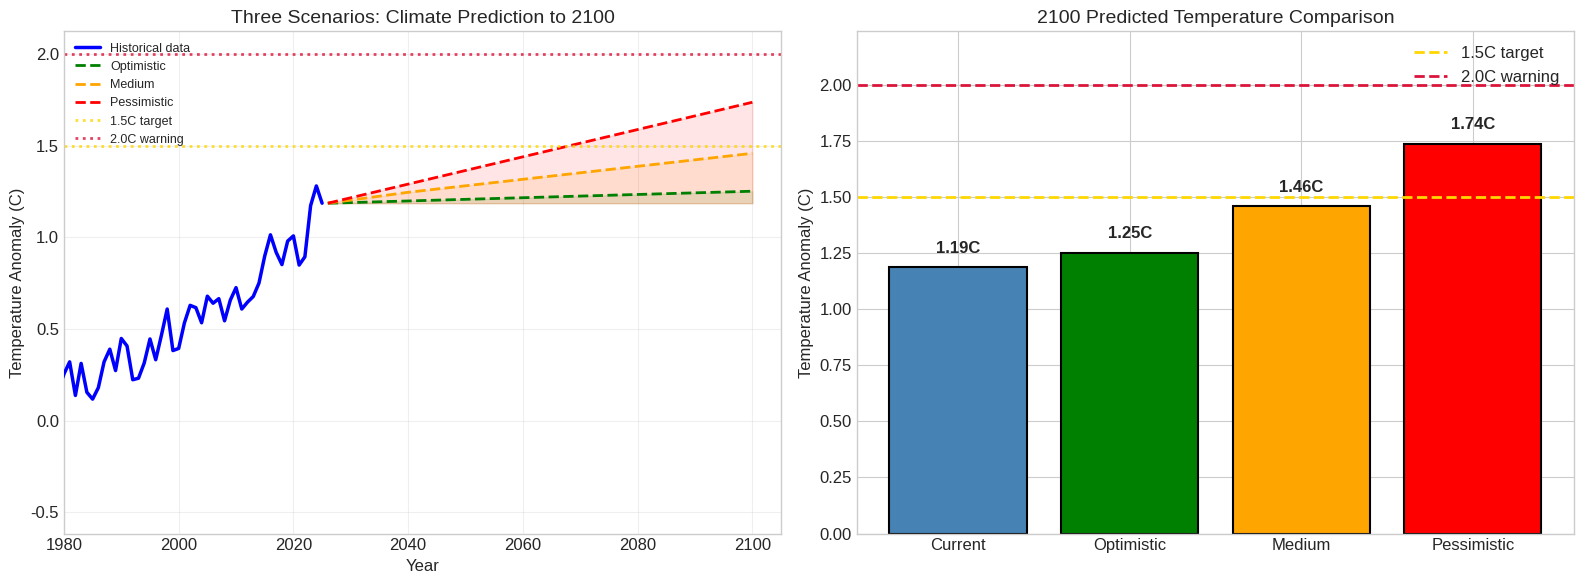


 三种情景对比（2100年预测）
 当前温度异常: 1.19C
-----------------------------------------------------------------
 乐观情景：积极减排
   -> 2100年预测: 1.25C (升温 +0.07C) [控制在安全范围]
 中等情景：维持现状
   -> 2100年预测: 1.46C (升温 +0.27C) [控制在安全范围]
 悲观情景：排放失控
   -> 2100年预测: 1.74C (升温 +0.55C) [超过1.5C目标]

 关键启示：尽早采取减排行动，可以避免最坏的结果！


In [24]:
#@title ## 4.2 三种情景对比 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，同时对比三种排放情景下的未来气候。
#@markdown
#@markdown 情景说明：
#@markdown - **乐观情景 Optimistic**：积极减排，2025年开始大规模行动
#@markdown - **中等情景 Medium**：维持现状，2040年开始缓慢减排
#@markdown - **悲观情景 Pessimistic**：排放失控，没有有效减排措施
#@markdown
#@markdown ---
#@markdown **图表说明：**
#@markdown
#@markdown | 图表 | 含义 |
#@markdown |------|------|
#@markdown | 左图 | **趋势对比**：三种情景下的温度变化曲线，展示不同选择带来的不同未来。 |
#@markdown | 右图 | **终点对比**：2100年各情景预测温度的柱状对比，一目了然。 |
#@markdown ---

def predict_scenario(co2_growth, reduction_year, end_year):
    """为特定情景生成预测"""
    last_sequence = scaled_data[-LOOKBACK:].copy()
    start_year = int(df_annual['Year'].max()) + 1
    future_years = list(range(start_year, end_year + 1))

    predictions = []
    current_sequence = last_sequence.flatten().tolist()

    base_temp = scaled_data[-1, 0]

    for year in future_years:
        X_input = np.array(current_sequence[-LOOKBACK:]).reshape(1, LOOKBACK, 1)
        pred = model.predict(X_input, verbose=0)[0, 0]

        years_elapsed = year - start_year

        if year < reduction_year:
            # 减排前：根据CO2增长率上升（高CO2增长更快）
            growth_factor = co2_growth / 100
            pred = base_temp + growth_factor * years_elapsed * 0.12  # 增大基础系数
        else:
            years_before = reduction_year - start_year
            temp_at_reduction = base_temp + (co2_growth / 100) * years_before * 0.12
            years_after = year - reduction_year

            if co2_growth <= 1.0:
                pred = temp_at_reduction + years_after * 0.0005
            elif co2_growth <= 2.5:
                pred = temp_at_reduction + years_after * 0.002
            else:
                pred = temp_at_reduction + years_after * 0.005

        pred = max(pred, base_temp)
        predictions.append(pred)
        current_sequence.append(pred)

    predictions_original = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return future_years, predictions_original.flatten()


# 三种情景
scenarios = [
    ('Optimistic', 0.5, 2025, 'green'),
    ('Medium', 2.0, 2040, 'orange'),
    ('Pessimistic', 3.5, 2100, 'red')
]

# 情景中文名称映射
scenario_names_cn = {
    'Optimistic': '乐观情景：积极减排',
    'Medium': '中等情景：维持现状',
    'Pessimistic': '悲观情景：排放失控'
}

end_year = 2100

# 绑图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左图：时间序列对比
ax1 = axes[0]

# 历史数据
ax1.plot(df_annual['Year'], df_annual['Temperature'], 'b-',
        linewidth=2.5, label='Historical data', zorder=5)

# 各情景预测
final_temps = []
for name, co2, reduction, color in scenarios:
    years, temps = predict_scenario(co2, reduction, end_year)
    ax1.plot(years, temps, '--', color=color, linewidth=2, label=name)
    ax1.fill_between(years, df_annual['Temperature'].iloc[-1], temps,
                    alpha=0.1, color=color)
    final_temps.append((name, temps[-1], color))

# 参考线（加入图例，不单独标注文字）
ax1.axhline(y=1.5, color='gold', linestyle=':', linewidth=2, alpha=0.8, label='1.5C target')
ax1.axhline(y=2.0, color='crimson', linestyle=':', linewidth=2, alpha=0.8, label='2.0C warning')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Temperature Anomaly (C)', fontsize=12)
ax1.set_title('Three Scenarios: Climate Prediction to 2100', fontsize=14)
ax1.legend(loc='upper left', fontsize=9)
ax1.set_xlim(1980, 2105)  # 缩小右边界
ax1.grid(True, alpha=0.3)

# 右图：柱状对比
ax2 = axes[1]

names = [f for f, _, _ in final_temps]
temps = [t for _, t, _ in final_temps]
colors = [c for _, _, c in final_temps]

# 包含当前温度
current_temp = df_annual['Temperature'].iloc[-1]
names = ['Current'] + names
temps = [current_temp] + temps
colors = ['steelblue'] + colors

bars = ax2.bar(names, temps, color=colors, edgecolor='black', linewidth=1.5)

# 添加数值标签
for bar, temp in zip(bars, temps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{temp:.2f}C',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# 警戒线
ax2.axhline(y=1.5, color='gold', linestyle='--', linewidth=2, label='1.5C target')
ax2.axhline(y=2.0, color='crimson', linestyle='--', linewidth=2, label='2.0C warning')

ax2.set_ylabel('Temperature Anomaly (C)', fontsize=12)
ax2.set_title('2100 Predicted Temperature Comparison', fontsize=14)
ax2.set_ylim(0, max(temps) + 0.5)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# 打印对比结果
print("\n" + "=" * 65)
print(" 三种情景对比（2100年预测）")
print("=" * 65)
print(f" 当前温度异常: {current_temp:.2f}C")
print("-" * 65)
for name, temp, _ in final_temps:
    increase = temp - current_temp
    if temp > 2.0:
        status = "突破2C警戒线"
    elif temp > 1.5:
        status = "超过1.5C目标"
    else:
        status = "控制在安全范围"
    name_cn = scenario_names_cn.get(name, name)
    print(f" {name_cn}")
    print(f"   -> 2100年预测: {temp:.2f}C (升温 {increase:+.2f}C) [{status}]")
print("=" * 65)
print("\n 关键启示：尽早采取减排行动，可以避免最坏的结果！")

---
<a id='part5'></a>
# 第五部分: 探索中国城市气候

在这一部分，你可以选择中国的城市，查看当地的气候变化趋势。

由于获取每个城市的详细历史数据需要专门的气象站数据，这里我们使用基于全球数据和地理位置的估算方法来展示不同城市的相对变化趋势。

---

In [ ]:
#@title ## 5.1 中国城市气候探索 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，选择你的家乡或感兴趣的城市，查看气候变化趋势！
#@markdown
#@markdown 包含城市：
#@markdown - 北方城市：北京、哈尔滨、西安、乌鲁木齐等
#@markdown - 南方城市：上海、广州、深圳、香港等
#@markdown - 西部城市：成都、重庆、昆明、拉萨等
#@markdown
#@markdown ---
#@markdown **图表说明：**
#@markdown
#@markdown | 图表 | 含义 |
#@markdown |------|------|
#@markdown | 左图 | **历史趋势**：该城市1880年至今的温度异常变化，黑线是10年移动平均。 |
#@markdown | 中图 | **全球对比**：蓝色是全球平均，红色是该城市，展示区域差异。 |
#@markdown | 右图 | **未来预测**：基于历史趋势预测到2100年的温度变化。 |
#@markdown ---

# 城市数据（纬度，区域调整系数，区域）
# 高纬度地区通常升温幅度更大
china_cities = {
    'Beijing': (39.9, 1.15, 'Northern'),
    'Shanghai': (31.2, 1.05, 'Eastern'),
    'Guangzhou': (23.1, 0.95, 'Southern'),
    'Shenzhen': (22.5, 0.93, 'Southern'),
    'Chengdu': (30.7, 1.00, 'Western'),
    'Chongqing': (29.6, 1.02, 'Western'),
    'Wuhan': (30.6, 1.08, 'Central'),
    'Xian': (34.3, 1.12, 'Northern'),
    'Hangzhou': (30.3, 1.03, 'Eastern'),
    'Nanjing': (32.1, 1.06, 'Eastern'),
    'Tianjin': (39.1, 1.14, 'Northern'),
    'Haerbin': (45.8, 1.25, 'Northern'),
    'Shenyang': (41.8, 1.20, 'Northern'),
    'Dalian': (38.9, 1.10, 'Northern'),
    'Qingdao': (36.1, 1.08, 'Eastern'),
    'Zhengzhou': (34.7, 1.10, 'Central'),
    'Changsha': (28.2, 1.04, 'Central'),
    'Fuzhou': (26.1, 0.98, 'Eastern'),
    'Xiamen': (24.5, 0.96, 'Southern'),
    'Kunming': (25.0, 0.88, 'Western'),
    'Guiyang': (26.6, 0.92, 'Western'),
    'Nanning': (22.8, 0.94, 'Southern'),
    'Haikou': (20.0, 0.90, 'Southern'),
    'Xianggang': (22.3, 0.92, 'Southern'),
    'Taibei': (25.0, 0.95, 'Eastern'),
    'Wulumuqi': (43.8, 1.30, 'Western'),
    'Lanzhou': (36.1, 1.18, 'Western'),
    'Lasa': (29.6, 1.22, 'Western'),
    'Huhehaote': (40.8, 1.22, 'Northern'),
    'Yinchuan': (38.5, 1.20, 'Western'),
}

# 城市中文名映射
city_names_cn = {
    'Beijing': '北京',
    'Shanghai': '上海',
    'Guangzhou': '广州',
    'Shenzhen': '深圳',
    'Chengdu': '成都',
    'Chongqing': '重庆',
    'Wuhan': '武汉',
    'Xian': '西安',
    'Hangzhou': '杭州',
    'Nanjing': '南京',
    'Tianjin': '天津',
    'Haerbin': '哈尔滨',
    'Shenyang': '沈阳',
    'Dalian': '大连',
    'Qingdao': '青岛',
    'Zhengzhou': '郑州',
    'Changsha': '长沙',
    'Fuzhou': '福州',
    'Xiamen': '厦门',
    'Kunming': '昆明',
    'Guiyang': '贵阳',
    'Nanning': '南宁',
    'Haikou': '海口',
    'Xianggang': '香港',
    'Taibei': '台北',
    'Wulumuqi': '乌鲁木齐',
    'Lanzhou': '兰州',
    'Lasa': '拉萨',
    'Huhehaote': '呼和浩特',
    'Yinchuan': '银川',
}

# 区域中文名映射
region_names_cn = {
    'Northern': '北方',
    'Southern': '南方',
    'Eastern': '东部',
    'Central': '中部',
    'Western': '西部',
    'All': '全部'
}

def explore_city_climate(city):
    """探索指定城市的气候变化"""

    lat, factor, region = china_cities[city]
    city_cn = city_names_cn.get(city, city)
    region_cn = region_names_cn.get(region, region)

    # 根据全球数据计算城市特定的温度变化
    city_temps = df_annual['Temperature'].values * factor

    # 未来预测（根据纬度调整增长速度）
    future_years_list = list(range(int(df_annual['Year'].max()) + 1, 2101))

    # 基于最近30年趋势
    recent_trend = np.polyfit(df_annual['Year'].values[-30:], city_temps[-30:], 1)
    base_slope = recent_trend[0]

    # 根据升温系数调整斜率（高纬度城市升温更快）
    adjusted_slope = base_slope * (0.3 + factor * 0.5)  # factor越大，斜率越陡

    # 从当前温度开始预测
    current_temp = city_temps[-1]
    current_year = df_annual['Year'].values[-1]
    future_temps = current_temp + adjusted_slope * (np.array(future_years_list) - current_year)

    # 创建可视化
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # 左图：历史趋势
    ax1 = axes[0]
    colors = ['#2166AC' if t < 0 else '#B2182B' for t in city_temps]
    ax1.bar(df_annual['Year'], city_temps, color=colors, alpha=0.7, width=0.8)
    ma = pd.Series(city_temps).rolling(window=10, center=True).mean()
    ax1.plot(df_annual['Year'], ma, 'k-', linewidth=2, label='10-year MA')
    ax1.axhline(y=0, color='gray', linestyle='--')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Temperature Anomaly (C)')
    ax1.set_title(f'{city} Historical Trend')
    ax1.legend()

    # 中图：与全球对比
    ax2 = axes[1]
    ax2.plot(df_annual['Year'], df_annual['Temperature'], 'b-',
            linewidth=2, label='Global', alpha=0.7)
    ax2.plot(df_annual['Year'], city_temps, 'r-',
            linewidth=2, label=city)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Temperature Anomaly (C)')
    ax2.set_title(f'{city} vs Global')
    ax2.legend()
    ax2.set_xlim(1950, df_annual['Year'].max())

    # 右图：未来预测
    ax3 = axes[2]
    ax3.plot(df_annual['Year'], city_temps, 'b-', linewidth=2, label='Historical')
    ax3.plot(future_years_list, future_temps, 'r--', linewidth=2, label='Prediction')
    ax3.axhline(y=1.5 * factor, color='orange', linestyle=':', label='1.5C target')
    ax3.axhline(y=2.0 * factor, color='red', linestyle=':', label='2.0C warning')
    ax3.fill_between(future_years_list, city_temps[-1], future_temps, alpha=0.2, color='red')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Temperature Anomaly (C)')
    ax3.set_title(f'{city} Prediction to 2100')
    ax3.legend(loc='upper left')
    ax3.set_xlim(1980, 2105)

    plt.tight_layout()
    plt.show()

    # 打印城市信息
    current_anomaly = city_temps[-1]
    future_2050 = np.interp(2050, future_years_list, future_temps)
    future_2100 = future_temps[-1]

    print("\n" + "=" * 60)
    print(f" {city_cn} 气候概况")
    print("=" * 60)
    print(f" 所属区域: {region_cn}")
    print(f" 纬度: 北纬 {lat}度")
    print(f" 升温系数: {factor:.2f} (1.0 = 全球平均)")
    print("-" * 60)
    print(f" 当前温度异常: {current_anomaly:.2f}C")
    print(f" 2050年预测: {future_2050:.2f}C")
    print(f" 2100年预测: {future_2100:.2f}C")
    print("-" * 60)

    # 区域分析
    if factor > 1.15:
        print(f" 分析: {city_cn}作为{region_cn}城市，纬度较高，")
        print(f"       升温幅度大于全球平均，需特别关注：")
        print(f"       - 极端寒潮频率变化")
        print(f"       - 供暖需求变化")
        print(f"       - 冻土退化问题")
    elif factor < 0.95:
        print(f" 分析: {city_cn}因纬度较低，升温相对温和，")
        print(f"       但仍需关注：")
        print(f"       - 降雨强度增加")
        print(f"       - 海平面上升风险")
        print(f"       - 热浪与高温天气")
    else:
        print(f" 分析: {city_cn}升温趋势接近全球平均，")
        print(f"       需综合关注：")
        print(f"       - 热浪频率增加")
        print(f"       - 洪涝灾害")
        print(f"       - 其他极端天气事件")
    print("=" * 60)

# 创建城市选择下拉框
city_dropdown = widgets.Dropdown(
    options=sorted(china_cities.keys()),
    value='Beijing',
    description='城市:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='300px')
)

# 添加区域筛选
region_dropdown = widgets.Dropdown(
    options=['All', 'Northern', 'Southern', 'Eastern', 'Central', 'Western'],
    value='All',
    description='区域:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='300px')
)

def update_cities(change):
    region = region_dropdown.value
    if region == 'All':
        city_dropdown.options = sorted(china_cities.keys())
    else:
        filtered = [city for city, (_, _, r) in china_cities.items() if r == region]
        city_dropdown.options = sorted(filtered)

region_dropdown.observe(update_cities, names='value')

print(" 选择一个城市，探索它的气候变化特征")
print(" 提示: 可以先按区域筛选，再选择城市")
print("-" * 50)

ui = widgets.HBox([region_dropdown, city_dropdown])
out = widgets.interactive_output(explore_city_climate, {'city': city_dropdown})

display(ui, out)

 选择一个城市，探索它的气候变化特征
 提示: 可以先按区域筛选，再选择城市
--------------------------------------------------


Output()

---
<a id='part6'></a>
# 第六部分: 总结与思考

恭喜你完成了整个AI气候预测实验！

---

## 你学到了什么？

| 知识领域 | 学习内容 |
|----------|----------|
| 气候科学 | 全球变暖趋势、温度异常的概念、不同时期的气候特征 |
| 人工智能 | LSTM神经网络原理、模型训练过程、参数调优 |
| 数据分析 | 数据可视化、趋势分析、情景对比 |
| 可持续发展 | 不同排放情景的影响、减排行动的重要性 |

---

In [ ]:
#@title ## 6.1 知识小测验 { display-mode: "form" }
#@markdown ---
#@markdown **运行此单元格**，通过小测验检验你的学习成果！
#@markdown ---

questions = [
    {
        'question': '1. 温度异常值为正数表示什么？',
        'options': ['比基准期更冷', '比基准期更暖', '与基准期相同', '数据错误'],
        'answer': 1,
        'explanation': '正的温度异常表示该时期温度高于基准期(1951-1980)平均值'
    },
    {
        'question': '2. LSTM神经网络的主要特点是什么？',
        'options': ['能处理图像', '能记住长期依赖关系', '运算速度最快', '只能处理文本'],
        'answer': 1,
        'explanation': 'LSTM (长短期记忆网络) 的核心优势是能够学习和记住时间序列中的长期依赖关系'
    },
    {
        'question': '3. 《巴黎协定》的全球升温控制目标是多少？',
        'options': ['控制在1.0C以内', '控制在1.5C以内', '控制在3.0C以内', '没有具体目标'],
        'answer': 1,
        'explanation': '《巴黎协定》目标是将全球平均气温升幅控制在2C以内，并努力限制在1.5C以内'
    },
    {
        'question': '4. 为什么高纬度地区升温幅度通常更大？',
        'options': ['人口更多', '冰雪反馈效应', '工业更发达', '测量误差'],
        'answer': 1,
        'explanation': '高纬度地区的冰雪融化后，反射率降低，吸收更多太阳能，形成正反馈，加剧升温'
    },
    {
        'question': '5. 训练AI模型时，损失函数值下降表示什么？',
        'options': ['模型变差', '模型预测越来越准确', '数据有问题', '需要停止训练'],
        'answer': 1,
        'explanation': '损失函数衡量预测值与真实值的差距，损失下降说明模型预测越来越准确'
    }
]

def run_quiz():
    score = 0

    print("=" * 60)
    print(" AI气候预测 知识小测验")
    print("=" * 60)
    print(" 请选择正确的答案选项 (A/B/C/D)\n")

    for i, q in enumerate(questions):
        print(f"\n{q['question']}")
        for j, opt in enumerate(q['options']):
            print(f"   {chr(65+j)}. {opt}")

    print("\n" + "-" * 60)
    print(" 在下方输入你的答案（例如：ABBCA）:")

def check_answers(answers):
    answers = answers.upper().strip()
    if len(answers) != len(questions):
        print(f" 请输入 {len(questions)} 个答案")
        return

    score = 0
    print("\n" + "=" * 60)
    print(" 答案解析")
    print("=" * 60)

    for i, (q, ans) in enumerate(zip(questions, answers)):
        user_answer = ord(ans) - ord('A')
        correct = user_answer == q['answer']
        if correct:
            score += 1

        status = "正确 ✓" if correct else "错误 ✗"
        print(f"\n 第{i+1}题: {status}")
        print(f"   你的答案: {ans}，正确答案: {chr(65+q['answer'])}")
        print(f"   解析: {q['explanation']}")

    print("\n" + "=" * 60)
    print(f" 最终得分: {score}/{len(questions)}")

    if score == len(questions):
        print(" 太棒了！你已经完全掌握了AI气候预测的核心概念！")
    elif score >= len(questions) * 0.6:
        print(" 不错！你理解了大部分概念，复习一下错题吧。")
    else:
        print(" 继续加油！建议重新学习课程内容后再试一次。")
    print("=" * 60)

run_quiz()

# 创建答案输入框
answer_input = widgets.Text(
    placeholder='在此输入答案，例如 ABBCA',
    description='答案:',
    style={'description_width': '80px'},
    layout=widgets.Layout(width='400px')
)

submit_button = widgets.Button(
    description='提交答案',
    button_style='primary',
    layout=widgets.Layout(width='150px')
)

output = widgets.Output()

def on_submit(b):
    with output:
        clear_output()
        check_answers(answer_input.value)

submit_button.on_click(on_submit)

display(widgets.HBox([answer_input, submit_button]))
display(output)

 AI气候预测 知识小测验
 请选择正确的答案选项 (A/B/C/D)


1. 温度异常值为正数表示什么？
   A. 比基准期更冷
   B. 比基准期更暖
   C. 与基准期相同
   D. 数据错误

2. LSTM神经网络的主要特点是什么？
   A. 能处理图像
   B. 能记住长期依赖关系
   C. 运算速度最快
   D. 只能处理文本

3. 《巴黎协定》的全球升温控制目标是多少？
   A. 控制在1.0C以内
   B. 控制在1.5C以内
   C. 控制在3.0C以内
   D. 没有具体目标

4. 为什么高纬度地区升温幅度通常更大？
   A. 人口更多
   B. 冰雪反馈效应
   C. 工业更发达
   D. 测量误差

5. 训练AI模型时，损失函数值下降表示什么？
   A. 模型变差
   B. 模型预测越来越准确
   C. 数据有问题
   D. 需要停止训练

------------------------------------------------------------
 在下方输入你的答案（例如：ABBCA）:


Output()

---
<a id='appendix'></a>
# 附录

---

## A. 常见问题 (FAQ)

**Q1: 为什么我的预测结果与同学不同？**

A: 神经网络训练存在随机性，每次训练的初始权重不同会导致结果略有差异。这是正常现象。

**Q2: AI预测的准确性如何？**

A: 本实验中的简化模型主要用于教学目的。真实的气候预测使用更复杂的模型和更多变量。但训练过程和原理是相同的。

**Q3: 为什么要用过去10年的数据预测？**

A: 这是「滑动窗口」的长度设置。使用过去10年的数据可以让模型学习到中期趋势，同时又不会因窗口太长而丢失近期变化。

**Q4: 能否预测更远的未来（如2200年）？**

A: 技术上可以，但预测越远，不确定性越大。超过100年的预测主要用于情景分析，而非精确预测。

---

## B. 拓展资源

| 资源 | 链接 | 说明 |
|------|------|------|
| NASA GISS | https://data.giss.nasa.gov/gistemp/ | 本实验使用的数据来源 |
| IPCC报告 | https://www.ipcc.ch/ | 政府间气候变化专门委员会 |
| Our World in Data | https://ourworldindata.org/climate-change | 气候变化数据可视化 |
| 国家气候中心 | https://www.ncc-cma.net/ | 中国气候科普网站 |
| TensorFlow教程 | https://www.tensorflow.org/tutorials | 深度学习框架官方教程 |

---

## C. 进阶学习建议

如果你对AI气候预测感兴趣，可以进一步学习：

1. **更复杂的模型**：GraphCast、Pangu-Weather、FourCastNet等前沿AI天气模型
2. **多变量预测**：同时考虑温度、降水、海平面等多个气候指标
3. **空间预测**：预测不同地区的气候变化差异
4. **极端事件**：使用AI预测极端天气事件的频率和强度

---

## D. 术语表

| 术语 | 解释 |
|------|------|
| 温度异常 | 某时期温度与基准期平均值的差值 |
| LSTM | 长短期记忆网络，一种循环神经网络 |
| 损失函数 | 衡量模型预测误差的指标 |
| 归一化 | 将数据缩放到特定范围（如0-1） |
| Epoch | 模型遍历全部训练数据一次 |
| Dropout | 防止过拟合的正则化技术 |
| IPCC | 政府间气候变化专门委员会 |
| 碳中和 | 排放的碳与吸收的碳相等 |

---

*本教学Notebook基于NASA GISTEMP数据开发，仅供教学使用。*

*如有问题或建议，欢迎反馈！*